In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
backbone1 = []
fn = "/home/robert/data/mode_s_ts_1000_nb_10000_seed_45_.dat"
print('reading', fn)
with open(fn, 'r') as fid:
    for row in fid:
        row = row.split()
        # extract the fiber center (rectangular trapezoid)
        v = np.zeros(5)
        if -8 <= int(row[2]) <=8:
            if -8 <= int(row[4]) <=8:
                if -100 <= int(row[3]) <=100:
                    #print(row)
                    v = [
                        int(row[1]),  # particle id
                        int(row[2]),  # x
                        int(row[3]),  # y
                        int(row[4]),  # z                        
                    ]
                    backbone1.append(v)

backbone1 = np.array(backbone1, dtype=np.int32)
# print(back_bone1)
# np.savetxt('./testeback.txt',backbone1,fmt='%f')

reading /home/robert/data/mode_s_ts_1000_nb_10000_seed_45_.dat


In [5]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in backbone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

FileNotFoundError: [Errno 2] No such file or directory: '/home/robert/gitrepos/dla-collagen/back_bone_teste.txt'

In [4]:
def generate_all_neigh(new):
    #Gera o vetor com 4 vizinhos de cada sítio
    new1 = new.copy()
    new2 = new.copy()
    new3 = new.copy()
    new4 = new.copy()

    new1[:,0] = new1[:,0] + 1
    new2[:,0] = new2[:,0] - 1
    new3[:,2] = new3[:,2] + 1
    new4[:,2] = new4[:,2] - 1

    #Junta tudo em um array
    new0 = np.vstack((new,new1))
    new0 = np.vstack((new0,new2))
    new0 = np.vstack((new0,new3))
    new0 = np.vstack((new0,new4))
    return new0

In [57]:
def filter_backbone(backbone1:np.ndarray, ascending:bool=True):
    xidx, yidx, zidx = 1, 2, 3
    # boolean indicating if the particle is in the backbone
    b = np.zeros(backbone1.shape[0], dtype=np.int8)
    
    # sort backbone1 by y coordinate
    backbone1 = backbone1[backbone1[:,yidx].argsort()]

    yMin = np.min(backbone1[:,yidx])
    yMax = np.max(backbone1[:,yidx])
    
    yLayer = yMin if ascending else yMax

    yRange = range(yMin+1, yMax+1) if ascending else range(yMax-1, yMin-1, -1)
    
    # find all particles in the current layer
    idx_prev = np.where(backbone1[:,yidx] == yLayer)[0]
    print(len(idx_prev))
    # mark the particles in the current layer that are neighbors of the previous layer
    b[idx_prev] = 1
    for yLayer in yRange:
        # find all particles in the current layer
        idx = np.where(backbone1[:,yidx] == yLayer)[0]
        # for all particle in the current layer, check if they are neighbors of the previous layer
        idxB = np.isin(backbone1[idx][:,[xidx, zidx]], backbone1[idx_prev][:,[xidx, zidx]])
        print('len(idxB)', len(idxB))
        idxB = np.all(idxB, axis=1)
        idxB = idx[idxB]
        # find neighbors in current layer considering xidx and zidx
        xzB = backbone1[idxB][:,[xidx,zidx]]
        idxN = list(set(idx) - set(idxB))
        print('total de vizinhos: %d' % len(idxN))
        xzN = backbone1[idxN][:,[xidx,zidx]]
        for i in range(len(idxN)):            
            xzn = xzN[i]
            keep = False
            # searching for neighbors in the current layer
            for xzb in xzB:
                if np.sum(np.abs(xzn-xzb)) == 1:
                    # there is a neighbor in the current layer
                    keep = True
                    break
            if not keep:
                # there is no neighbor in the current layer
                del idxN[i]
        # mark the particles in the current layer that are neighbors of the previous layer
        idx_prev = np.array(idxB.tolist() + idxN, dtype=np.int32)
        
        print('total na camada: %d' %len(idx_prev))
        b[idx_prev] = 1
    return backbone1[b==1]

In [70]:
v = []

for k in range(20):
    l = [k, random.randint(0,5), random.randint(0,5), random.randint(0,5)]
    v.append(l)

In [71]:
v = np.array(v, dtype=np.int8)
print(v)
v = v[v[:,2].argsort()]
print(v)

bt = filter_backbone(v)


[[ 0  3  2  4]
 [ 1  3  0  5]
 [ 2  2  3  1]
 [ 3  4  5  4]
 [ 4  2  2  2]
 [ 5  3  4  1]
 [ 6  0  2  5]
 [ 7  1  2  0]
 [ 8  3  0  1]
 [ 9  1  2  1]
 [10  5  1  3]
 [11  4  1  5]
 [12  5  1  2]
 [13  4  3  4]
 [14  1  4  0]
 [15  5  1  2]
 [16  2  1  1]
 [17  0  5  2]
 [18  3  0  5]
 [19  0  1  0]]
[[ 1  3  0  5]
 [18  3  0  5]
 [ 8  3  0  1]
 [19  0  1  0]
 [16  2  1  1]
 [15  5  1  2]
 [12  5  1  2]
 [11  4  1  5]
 [10  5  1  3]
 [ 0  3  2  4]
 [ 6  0  2  5]
 [ 4  2  2  2]
 [ 7  1  2  0]
 [ 9  1  2  1]
 [13  4  3  4]
 [ 2  2  3  1]
 [ 5  3  4  1]
 [14  1  4  0]
 [ 3  4  5  4]
 [17  0  5  2]]
3
6
total de vizinhos: 5


IndexError: list assignment index out of range

In [58]:
bb2 = filter_backbone(backbone1, ascending=True)

159
128
total de vizinhos: 0
total na camada: 128
128
total de vizinhos: 0
total na camada: 128
162
total de vizinhos: 0
total na camada: 162
162
total de vizinhos: 0
total na camada: 162
133
total de vizinhos: 0
total na camada: 133
133
total de vizinhos: 0
total na camada: 133
169
total de vizinhos: 0
total na camada: 169
169
total de vizinhos: 0
total na camada: 169
131
total de vizinhos: 0
total na camada: 131
131
total de vizinhos: 0
total na camada: 131
167
total de vizinhos: 0
total na camada: 167
167
total de vizinhos: 0
total na camada: 167
134
total de vizinhos: 0
total na camada: 134
134
total de vizinhos: 0
total na camada: 134
163
total de vizinhos: 0
total na camada: 163
163
total de vizinhos: 0
total na camada: 163
135
total de vizinhos: 0
total na camada: 135
135
total de vizinhos: 0
total na camada: 135
164
total de vizinhos: 0
total na camada: 164
164
total de vizinhos: 0
total na camada: 164
130
total de vizinhos: 0
total na camada: 130
130
total de vizinhos: 0
total

In [43]:
print(len(np.isin(bb2,backbone1)))
l1 = backbone1[backbone1[: ,2] == -100]
print(l1)
l2 = backbone1

28757
[[ 999    2 -100    3]
 [1570   -3 -100    4]
 [2953   -4 -100    7]
 [6671    2 -100   -5]
 [4826    5 -100    0]
 [3948    4 -100    6]
 [ 955    2 -100    2]
 [1573    4 -100   -1]
 [3123   -1 -100   -4]
 [ 514   -3 -100    0]
 [ 510    1 -100   -1]
 [8564   -8 -100    2]
 [ 104   -1 -100    2]
 [8554    2 -100   -7]
 [3642    2 -100    7]
 [ 417    1 -100    1]
 [1308   -4 -100   -3]
 [ 524    1 -100   -2]
 [1708    4 -100    0]
 [ 446    1 -100    3]
 [ 886   -4 -100    1]
 [5707   -2 -100   -5]
 [8018    2 -100   -6]
 [5680   -7 -100    7]
 [ 246    0 -100    2]
 [2675   -6 -100    6]
 [3266    0 -100   -4]
 [ 256   -1 -100   -2]
 [8417   -8 -100    1]
 [2346   -5 -100    6]
 [3319   -7 -100   -2]
 [1280    3 -100   -2]
 [4480   -4 -100   -5]
 [3190    4 -100    5]
 [6377    5 -100    6]
 [2534   -2 -100    7]
 [4443    1 -100   -4]
 [2670    3 -100    4]
 [ 251    1 -100    2]
 [ 456    0 -100   -2]
 [ 403    0 -100    3]
 [7013   -7 -100    8]
 [6453   -2 -100   -6]
 [673

In [13]:
backbone1
ascending = True
xidx, yidx, zidx = 1, 2, 3
# boolean indicating if the particle is in the backbone
b = np.zeros(backbone1.shape[0], dtype=np.int8)

# sort backbone1 by y coordinate
backbone1 = backbone1[backbone1[:,yidx].argsort()]

yMin = np.min(backbone1[:,yidx])
yMax = np.max(backbone1[:,yidx])

yLayer = yMin if ascending else yMax

yRange = range(yMin+1, yMax+1) if ascending else range(yMax-1, yMin-1, -1)

# find all particles in the current layer
idx_prev = np.where(backbone1[:,yidx] == yLayer)[0]

# mark the particles in the current layer that are neighbors of the previous layer
b[idx_prev] = 1
for yLayer in range(-99):
    # find all particles in the current layer
    idx = np.where(backbone1[:,yidx] == yLayer)[0]
    # for all particle in the current layer, check if they are neighbors of the previous layer
    idxB = np.isin(backbone1[idx][:,[xidx, zidx]], backbone1[idx_prev][:,[xidx, zidx]])
    idxB = np.all(idxB, axis=1)
    idxB = idx[idxB]
    # find neighbors in current layer considering xidx and zidx
    xzB = backbone1[idxB][:,[xidx,zidx]]
    idxN = list(set(idx) - set(idxB))
    xzN = backbone1[idxN][:,[xidx,zidx]]
    for i in range(len(idxN)):            
        xzn = xzN[i]
        keep = False
        # searching for neighbors in the current layer
        for xzb in xzB:
            if np.sum(np.abs(xzn-xzb)) == 1:
                # there is a neighbor in the current layer
                keep = True
                break
        if not keep:
            # there is no neighbor in the current layer
            del idxN[i]
    # mark the particles in the current layer that are neighbors of the previous layer
    idx_prev = np.array(idxB.tolist() + idxN, dtype=np.int32)
    b[idx_prev] = 1
print(b)

[1 1 1 ... 0 0 0]


In [31]:
l1 = backbone1[b==1]

teste = [2 ,99,3]
print(backbone1[backbone1[:, [1,2,3] ==  teste]])



[]


In [33]:
bb2 = filter_backbone(backbone1, ascending=True)
print(bb2)
print(len(bb2[bb2[:, 2] == -95]))

[[ 999    2 -100    3]
 [6196    1 -100   -5]
 [1947   -5 -100   -2]
 ...
 [6493   -5  100    5]
 [5037   -5  100   -5]
 [5165    4  100   -8]]
133


In [607]:
backbone1 = np.array(backbone1).astype(int)
back_bone,N = filter_backbone(backbone1,-100,+1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone])
back_bone,N = filter_backbone(back_bone,100,-1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone]).astype(int)

In [592]:
def generate_probability(back_bone,F = 1,sigma_c = 1,m = 1):
    ids = np.unique(back_bone[:,0],return_counts=True)[0].astype(int)
    number = np.unique(back_bone[:,0],return_counts=True)[1].astype(int)
    ids = ids[np.argsort(number)[::-1]]
    number = number[np.argsort(number)[::-1]]
    probabilidade = []
    back_bone = back_bone.astype(int)
    for id in ids:
        sitio = np.array(back_bone[back_bone.astype(int)[:,0] == id].astype(int))[:,1:-1]
        vizinhos = generate_all_neigh(sitio)
        n = np.array([len(back_bone[back_bone[:,2] == i[1]]) for i in sitio])

        n = F/n
        sigma_ = np.mean(n)

        n_ = len([i for i in vizinhos if(i.tolist() in back_bone[:,1:-1].tolist())]) - len(sitio)

        P = (sigma_/n_*sigma_c)**m
        probabilidade.append([id,P,len(sitio)])
    probabilidade = np.array(probabilidade)
    return probabilidade

In [593]:
def remover(vetor,elemento):
    a = np.arange(len(vetor))
    a = a[vetor == elemento]
    print(a)
    return a

In [599]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [598]:
t = []
back_bone1 = np.copy(back_bone)
for F in range(0,110,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
    print(t)
t = np.array(t)

0
[3331.0]
10
[3331.0, 3330.0]
20
[3331.0, 3330.0, 3321.0]
30
[3331.0, 3330.0, 3321.0, 3307.0]
40
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0]
50
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0]
60
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0, 3210.0]
70
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0, 3210.0, 3181.0]
80
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0, 3210.0, 3181.0, 3127.0]
90
[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0, 3210.0, 3181.0, 3127.0, 3078.0]
100


/home/robert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


[3331.0, 3330.0, 3321.0, 3307.0, 3255.0, 3229.0, 3210.0, 3181.0, 3127.0, 3078.0, 2981.0]


In [597]:
t

array([3331., 3330., 3321., 3307., 3255., 3229., 3210., 3181., 3127.,
       3078., 2981.])

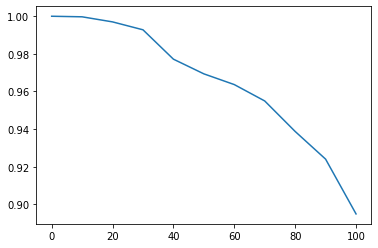

In [596]:
plt.plot(np.array(range(0,110,10)),t/t[0])
plt.show()

In [443]:
backbone = back_bone.astype(int)

In [448]:
back_bone[back_bone[:,2] == 10]

array([[182.,   0.,  10.,  -5.,   0.],
       [ 22.,   1.,  10.,   2.,   0.],
       [  4.,   1.,  10.,  -1.,   0.],
       [ 37.,   0.,  10.,   1.,   0.],
       [ 53.,   0.,  10.,  -4.,   0.],
       [  8.,   2.,  10.,  -1.,   0.],
       [156.,   3.,  10.,  -1.,   0.],
       [ 89.,  -1.,  10.,   1.,   0.],
       [125.,   3.,  10.,  -2.,   0.],
       [ 30.,   1.,  10.,   3.,   0.]])

[array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape

In [ ]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in back_bone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

In [ ]:
np.savetxt("./back.txt", back_bone[:,1:-1],fmt = "%d", delimiter=' ')

In [ ]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [ ]:
##

F = 1
stress_i = np.array(201)


array([[  1, -99,   0],
       [  0, -99,   0],
       [ -1, -99,   1],
       [ -1, -99,  -4],
       [ -2, -99,  -4],
       [  0, -99,  -4],
       [  0, -99,  -3],
       [  4, -99,  -2],
       [ -4, -99,   1],
       [ -3, -99,   1],
       [  5, -99,  -2],
       [ -5, -99,   0],
       [ -3, -99,   0],
       [  2, -99,   2],
       [ -6, -99,   0],
       [ -7, -99,   0],
       [  3, -99,  -7],
       [ -7, -99,  -1],
       [  5, -99,  -1],
       [  5, -99,   0],
       [  6, -99,  -1],
       [  0, -99,   6],
       [ -3, -99,  -4],
       [  1, -99,  -4],
       [ -4, -99,  -4],
       [  6, -99,  -5],
       [  7, -99,  -5],
       [ -5, -99,  -4],
       [  0, -99,   7],
       [ -4, -99,  -5],
       [  6, -99,  -4],
       [  9, -99,  -7],
       [  7, -99,  -4],
       [  5, -99,   6],
       [  9, -99,  -8],
       [ -1, -99,   7],
       [  8, -99,  -8],
       [ -2, -99,   7],
       [  5, -99,   7],
       [ -7, -99,   4],
       [  8, -99,  -4],
       [  7, -99

(47, 3)

In [ ]:
#print(len(back_bone1))
back_bone2 = []
print('tamanho back_bone1: %d' %len(back_bone1))

### Encotra todas as part. da primeira camada(y = -100) e marca como conectado
for j in back_bone1:
            
    if j[2] == -100:
        #print(entrou)
        part = [j[0], j[1], j[2], j[3], j[4] +1]
        back_bone2.append(part)
        #print(back_bone2)

    else:
        continue

### Encontra os vizinhos na segunda camada das part. marcadas na primeira camada
layer = []
plane = []
for i in back_bone2:
    part = [i[0], i[1], i[2]  + 1, i[3], i[4]]
    
    for j in back_bone1:

        if part[1] == j[1] and part[2] == j[2] and part[3] == j[3]:
            part[4] = 1
            layer.append(part)
        
print(len(layer))

### Encontra os vizinhos das part. na segunda camada
print(len(layer))
for i in layer:
    neigh1 = [i[0], i[1] + 1, i[2], i[3], i[4]]
    neigh2 = [i[0], i[1] - 1, i[2], i[3], i[4]]
    neigh3 = [i[0], i[1], i[2], i[3] + 1, i[4]]
    neigh4 = [i[0], i[1], i[2], i[3] - 1, i[4]]


    for j in back_bone1:

        if neigh1[1] == j[1]:
            if neigh1[2] == j[2]:
                if neigh1[3] == j[3]:
                    neigh1[4] = 1
                    layer.append(neigh1)

        if neigh2[1] == j[1]:
            if neigh2[2] == j[2]:
                if neigh2[3] == j[3]:
                    neigh2[4] = 1
                    layer.append(neigh2)

        if neigh3[1] == j[1]:
            if neigh3[2] == j[2]:
                if neigh3[3] == j[3]:
                    neigh3[4] = 1
                    layer.append(neigh3)

        if neigh4[1] == j[1]:
            if neigh4[2] == j[2]:
                if neigh4[3] == j[3]:
                    neigh4[4] = 1
                    layer.append(neigh4)



        

#print('plane: %d' %len(plane))
print(len(layer))
### Adiciona as part. conectadas da segunda camada no back_bone2


tamanho back_bone1: 8431
45
45


KeyboardInterrupt: 

In [ ]:
for i in back_bone1:
    if i[2] == -99:
        #print(i)
        #print(type(i))
        c = 0
a = [112, -1, -98, 1, 0]
if a in back_bone1:
    print("ok")
else:
    print('no')


no


In [ ]:
part = [51.0, 0.0, -99.0, 0.0, 1]
for i in back_bone1:
    if part[1] == i[1] and part[2] == i[2] and part[3] == i[3]:
        print(part)
        print(i)

[51.0, 0.0, -99.0, 0.0, 1]
[51.0, 0.0, -99.0, 0.0, 0.0]


In [ ]:
for i in back_bone1:

    if i[2] == -99:
        print(i)

[51.0, 0.0, -99.0, 0.0, 0.0]
[112.0, -2.0, -99.0, 1.0, 0.0]
[136.0, -2.0, -99.0, -4.0, 0.0]
[138.0, -3.0, -99.0, -4.0, 0.0]
[144.0, -1.0, -99.0, -4.0, 0.0]
[171.0, -1.0, -99.0, -3.0, 0.0]
[196.0, 3.0, -99.0, -2.0, 0.0]
[248.0, -5.0, -99.0, 1.0, 0.0]
[287.0, 4.0, -99.0, -2.0, 0.0]
[302.0, -6.0, -99.0, 0.0, 0.0]
[313.0, -4.0, -99.0, 0.0, 0.0]
[338.0, 1.0, -99.0, 2.0, 0.0]
[355.0, 4.0, -99.0, -5.0, 0.0]
[414.0, -7.0, -99.0, 0.0, 0.0]
[417.0, -8.0, -99.0, 0.0, 0.0]
[420.0, 2.0, -99.0, -7.0, 0.0]
[437.0, -8.0, -99.0, -1.0, 0.0]
[438.0, 4.0, -99.0, -1.0, 0.0]
[458.0, 4.0, -99.0, 0.0, 0.0]
[470.0, 5.0, -99.0, -1.0, 0.0]
[549.0, -4.0, -99.0, 5.0, 0.0]
[553.0, -1.0, -99.0, 6.0, 0.0]
[584.0, -4.0, -99.0, -4.0, 0.0]
[674.0, 0.0, -99.0, -4.0, 0.0]
[698.0, -5.0, -99.0, -4.0, 0.0]
[704.0, 5.0, -99.0, -5.0, 0.0]
[758.0, 6.0, -99.0, -5.0, 0.0]
[764.0, -6.0, -99.0, -4.0, 0.0]
[905.0, -1.0, -99.0, 7.0, 0.0]
[979.0, -5.0, -99.0, -5.0, 0.0]
[1003.0, 5.0, -99.0, -4.0, 0.0]
[1046.0, 8.0, -99.0, -7.0, 0.0]
[

In [ ]:
#print(back_bone2)
with open("/home/robert/gitrepos/dla-collagen/back_bone2_teste.txt", 'w') as fid:
    for i in back_bone2:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

[[51.0, 0.0, -99.0, 0.0, 0], [67.0, -1.0, -99.0, 0.0, 0], [112.0, -2.0, -99.0, 1.0, 0], [136.0, -2.0, -99.0, -4.0, 0], [138.0, -3.0, -99.0, -4.0, 0], [144.0, -1.0, -99.0, -4.0, 0], [171.0, -1.0, -99.0, -3.0, 0], [196.0, 3.0, -99.0, -2.0, 0], [248.0, -5.0, -99.0, 1.0, 0], [271.0, -4.0, -99.0, 1.0, 0], [287.0, 4.0, -99.0, -2.0, 0], [302.0, -6.0, -99.0, 0.0, 0], [313.0, -4.0, -99.0, 0.0, 0], [338.0, 1.0, -99.0, 2.0, 0], [414.0, -7.0, -99.0, 0.0, 0], [417.0, -8.0, -99.0, 0.0, 0], [420.0, 2.0, -99.0, -7.0, 0], [437.0, -8.0, -99.0, -1.0, 0], [438.0, 4.0, -99.0, -1.0, 0], [458.0, 4.0, -99.0, 0.0, 0], [470.0, 5.0, -99.0, -1.0, 0], [553.0, -1.0, -99.0, 6.0, 0], [584.0, -4.0, -99.0, -4.0, 0], [674.0, 0.0, -99.0, -4.0, 0], [698.0, -5.0, -99.0, -4.0, 0], [704.0, 5.0, -99.0, -5.0, 0], [758.0, 6.0, -99.0, -5.0, 0], [764.0, -6.0, -99.0, -4.0, 0], [905.0, -1.0, -99.0, 7.0, 0], [979.0, -5.0, -99.0, -5.0, 0], [1003.0, 5.0, -99.0, -4.0, 0], [1046.0, 8.0, -99.0, -7.0, 0], [1065.0, 6.0, -99.0, -4.0, 0], [1